In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 64
t_pra::Float64 = 0.3
filling::Float64 = 0.85
U::Float64 = 3
#U = 0.75
hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
mixing = 0.4   #ratio of mixing of Green function between new and old one
max = 0.0      #maximum value of difference between new adn old Green function
stoner = 0.0   #stoner factor
prestoner = 0.0
var = IRFLEX.Variables(mixing, max, stoner, prestoner)
;

In [7]:
ratio_U = 0.0
precision = 1e-6
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
sol = IRFLEX.SingleSCFSolution(true, precision, loose_precision, ratio_U, lat.freemu, gkf0)
;

In [8]:
@time var_new, full_sol=IRFLEX.flex_exe(sol, lat, var, basis)
;

Current value of U = 0.0
Trying U = 1.5 with mixing = 0.4
alpha_s=0.6826369558599428
chemical potential shift=0.005727615979298939
max=7.60650767541017, U=1.5
alpha_s=0.6565438625878633
chemical potential shift=0.004796216544563414
max=3.739957916999135, U=1.5
alpha_s=0.6426184780564416
chemical potential shift=0.00433951679957012
max=1.957068596213435, U=1.5
alpha_s=0.6350948496067642
chemical potential shift=0.0041075533448102775
max=1.147553842963684, U=1.5
alpha_s=0.6309921126742595
chemical potential shift=0.003987682723245678
max=0.6798499543172581, U=1.5
alpha_s=0.6287378622011506
chemical potential shift=0.003925236424447309
max=0.40590675234351276, U=1.5
alpha_s=0.6274912140550684
chemical potential shift=0.0038926042013052164
max=0.24376814910973252, U=1.5
alpha_s=0.6267977625851736
chemical potential shift=0.0038755465538966583
max=0.14702828870748313, U=1.5
alpha_s=0.6264099117439498
chemical potential shift=0.003866642386818553
max=0.08895471177256017, U=1.5
alpha_s=0.6261

alpha_s=0.9281474805284122
chemical potential shift=-0.007507512595711807
max=0.05283441361070773, U=3.0
alpha_s=0.9282598925388678
chemical potential shift=-0.0074985515707231
max=0.03716997902971891, U=3.0
alpha_s=0.9283158885652456
chemical potential shift=-0.007494963066344118
max=0.024842264197944004, U=3.0
alpha_s=0.9283438390736876
chemical potential shift=-0.007493554070847397
max=0.016050725933169183, U=3.0
alpha_s=0.9283578486291549
chemical potential shift=-0.007493006510360889
max=0.010136420410229942, U=3.0
alpha_s=0.9283649191037577
chemical potential shift=-0.007492790408419214
max=0.006493913400526297, U=3.0
alpha_s=0.9283685238442961
chemical potential shift=-0.007492699127670477
max=0.0041517861064118726, U=3.0
alpha_s=0.9283703869970442
chemical potential shift=-0.007492654869480031
max=0.0026272424719877697, U=3.0
alpha_s=0.9283713667330731
chemical potential shift=-0.007492629360332348
max=0.0016492303376521805, U=3.0
alpha_s=0.9283718924860591
chemical potential s

In [9]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(full_sol.gkf, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
chickf = chi0kf ./ (1.0 .+ lat.U*chi0kf)
Vkf = IRFLEX.calc_Vph(chiskf, chickf, chi0kf, 1.0, lat, basis)
sekf = IRFLEX.calc_se(full_sol.gkf, Vkf, lat, basis)
;

In [10]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

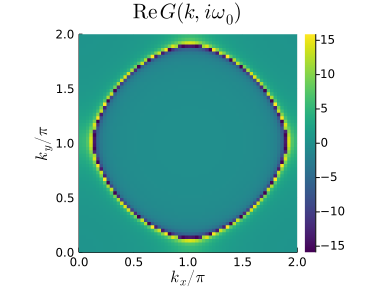

In [11]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

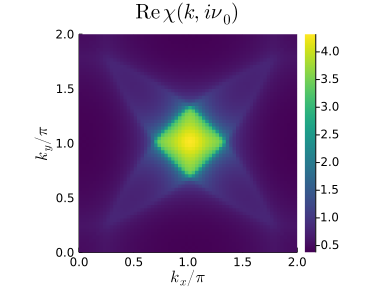

In [12]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [13]:
chi0kf[hnw+1,nsize÷2+1, nsize÷2+1]

0.30945752465336074 - 3.0719188831082075e-16im

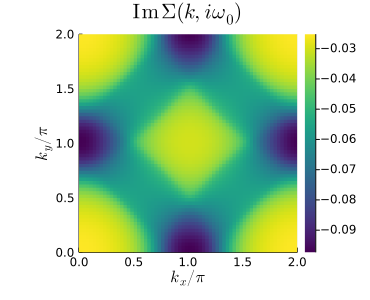

In [14]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, imag.(sekf[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Im}\\,\\Sigma(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [15]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [16]:
chisf = chiskf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

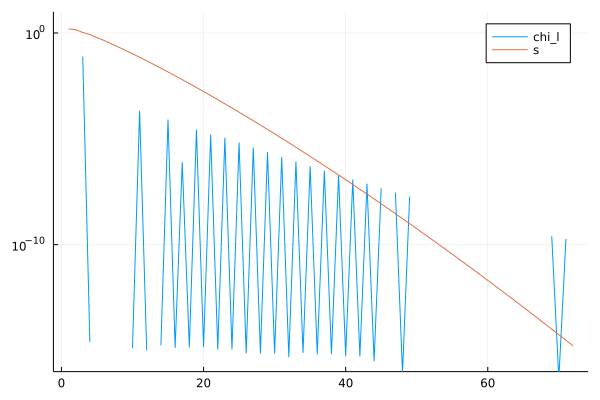

In [17]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [18]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

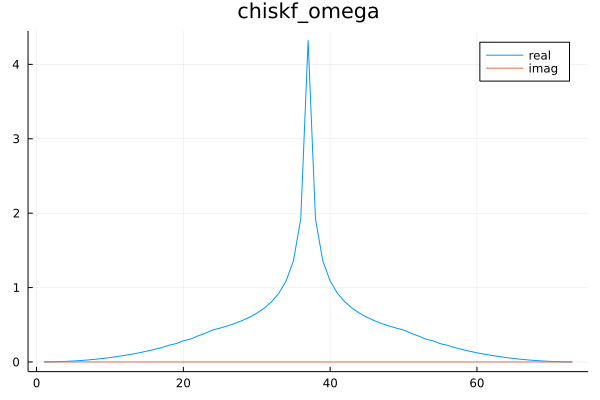

In [19]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

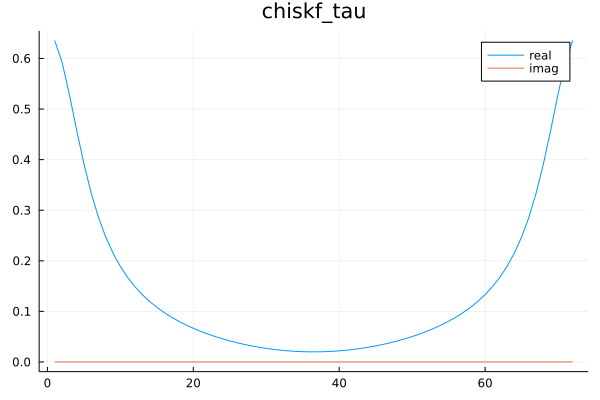

In [20]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [21]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

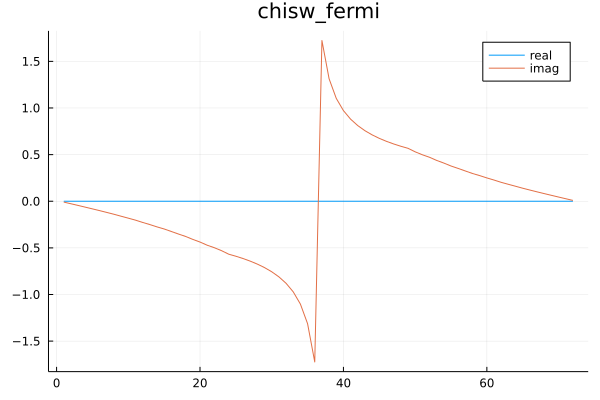

In [22]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [23]:
sum_rule::Float64 = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

1.2924552641058917

In [24]:
setprecision(512)

512

In [25]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [26]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [27]:
N_real    =  6000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 15
N_imag 15


In [28]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.042567e+00     4.804088e+00
 * time: 0.015651941299438477
     1     9.969638e-01     1.975026e+00
 * time: 3.6455180644989014
     2     3.968600e-01     8.448425e-01
 * time: 5.4785730838775635
     3     2.341398e-01     5.501432e-01
 * time: 7.314990997314453
     4     1.860330e-01     1.990979e-01
 * time: 9.1560959815979
     5     1.855343e-01     3.350984e-02
 * time: 10.413777112960815
     6     1.855306e-01     1.133901e-04
 * time: 12.331627130508423
     7     1.855306e-01     1.684319e-07
 * time: 13.58703899383545
     8     1.855306e-01     4.594261e-08
 * time: 14.882596969604492
     9     1.855306e-01     2.006280e-09
 * time: 16.779750108718872
max_theta=0.415747477288632810376708892878889355458825354825814509715957041317539342213307354721406203683727885510570286723058636326786992128260726113512609112891710147
hardy optimization was success.
 51.269046 seconds (341.81 M

In [29]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     1.855306e-01     2.006280e-09
 * time: 0.00018787384033203125
max_theta=0.415747477288632810376708892878889355458825354825814509715957041317539342213307354721406203683727885510570286723058636326786992128260726113512609112891710147
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     1.855306e-01     8.206240e-01
 * time: 0.00018405914306640625
     1     1.839186e-01     7.330172e-01
 * time: 2.0589518547058105
     2     5.128099e-02     5.416727e-01
 * time: 4.0459489822387695
     3     3.543913e-02     2.248763e-01
 * time: 5.404644012451172
     4     3.500640e-02     1.351990e-01
 * time: 7.497550964355469
     5     3.466524e-02     1.341489e-02
 * time: 9.574097871780396
     6     3.463998e-02     6.581807e-02
 * time: 12.316167831420898
     7     3.454681e-02     2.812870e-02
 * time: 15.14802098274231
     8     3.454381e-02     7.491856e-04
 * time: 17.21671485900879
     9     3.454

    73     1.786298e-02     2.970262e-03
 * time: 176.88344812393188
    74     1.786038e-02     3.179691e-03
 * time: 178.5675151348114
    75     1.785643e-02     1.401410e-03
 * time: 180.94048714637756
    76     1.785466e-02     1.306828e-03
 * time: 182.64010310173035
    77     1.785302e-02     1.109848e-03
 * time: 184.2395739555359
    78     1.785157e-02     8.438679e-04
 * time: 185.847718000412
    79     1.785051e-02     1.148296e-03
 * time: 187.5473530292511
    80     1.784955e-02     9.118670e-04
 * time: 189.13071012496948
    81     1.784880e-02     6.032239e-04
 * time: 190.7556450366974
    82     1.784766e-02     1.331724e-03
 * time: 193.22277998924255
    83     1.784712e-02     1.214248e-03
 * time: 194.82726407051086
    84     1.784681e-02     7.135245e-04
 * time: 196.52697706222534
    85     1.784661e-02     5.853298e-04
 * time: 198.11188006401062
    86     1.784640e-02     2.178746e-04
 * time: 199.72925209999084
    87     1.784624e-02     4.359337e-04

     5     1.306666e-02     2.129982e-02
 * time: 11.064342975616455
     6     1.236811e-02     9.767376e-03
 * time: 14.359485864639282
     7     1.129651e-02     2.471294e-02
 * time: 16.9563570022583
     8     1.090074e-02     6.708646e-03
 * time: 19.604482889175415
     9     1.054324e-02     1.689519e-02
 * time: 22.118385791778564
    10     1.005082e-02     1.619100e-02
 * time: 24.58601689338684
    11     9.960891e-03     1.419565e-02
 * time: 26.26516890525818
    12     9.806599e-03     7.108030e-03
 * time: 27.90539789199829
    13     9.681288e-03     1.294807e-02
 * time: 30.56748080253601
    14     9.507318e-03     1.264304e-02
 * time: 33.76961588859558
    15     9.294851e-03     5.830150e-03
 * time: 36.307753801345825
    16     9.095666e-03     5.436604e-03
 * time: 38.03015995025635
    17     8.951657e-03     4.266764e-03
 * time: 39.681410789489746
    18     8.861592e-03     2.796257e-03
 * time: 42.15063285827637
    19     8.813801e-03     1.225693e-03
 *

   125     8.504592e-03     8.049776e-06
 * time: 248.2711420059204
   126     8.504592e-03     7.613699e-06
 * time: 249.87352585792542
   127     8.504592e-03     7.789763e-06
 * time: 251.55848383903503
   128     8.504591e-03     7.233510e-06
 * time: 253.29161190986633
   129     8.504591e-03     7.304185e-06
 * time: 254.9491949081421
   130     8.504591e-03     7.007942e-06
 * time: 256.63649797439575
   131     8.504590e-03     6.642141e-06
 * time: 259.153883934021
   132     8.504590e-03     6.822606e-06
 * time: 260.84958600997925
   133     8.504590e-03     5.909662e-06
 * time: 262.57369685173035
   134     8.504590e-03     6.593540e-06
 * time: 264.21494579315186
   135     8.504590e-03     5.213885e-06
 * time: 265.8348739147186
   136     8.504589e-03     6.266811e-06
 * time: 267.48659491539
   137     8.504589e-03     4.626783e-06
 * time: 269.2642538547516
   138     8.504589e-03     5.820112e-06
 * time: 271.6193859577179
   139     8.504589e-03     4.183734e-06
 * 

   245     8.504587e-03     8.579917e-08
 * time: 459.43805599212646
   246     8.504587e-03     1.051926e-07
 * time: 461.048063993454
   247     8.504587e-03     7.678180e-08
 * time: 462.6143889427185
   248     8.504587e-03     9.958678e-08
 * time: 464.25062680244446
   249     8.504587e-03     6.884352e-08
 * time: 465.922385931015
   250     8.504587e-03     9.247058e-08
 * time: 468.40680480003357
   251     8.504587e-03     6.202409e-08
 * time: 470.1286389827728
   252     8.504587e-03     8.390921e-08
 * time: 471.87217688560486
   253     8.504587e-03     5.638274e-08
 * time: 473.56051683425903
   254     8.504587e-03     7.450915e-08
 * time: 475.2674708366394
   255     8.504587e-03     5.199242e-08
 * time: 476.93975496292114
   256     8.504587e-03     6.522636e-08
 * time: 479.3696539402008
   257     8.504587e-03     4.880120e-08
 * time: 481.1143538951874
   258     8.504587e-03     5.703505e-08
 * time: 482.84333992004395
   259     8.504587e-03     4.651636e-08
 *

    60     7.666094e-03     2.459059e-04
 * time: 136.12251710891724
    61     7.665865e-03     2.492214e-04
 * time: 137.9891390800476
    62     7.665602e-03     2.388541e-04
 * time: 139.89947700500488
    63     7.665349e-03     2.217880e-04
 * time: 141.83482313156128
    64     7.665006e-03     2.176172e-04
 * time: 143.81389617919922
    65     7.664698e-03     1.525729e-04
 * time: 145.79460310935974
    66     7.663958e-03     3.705643e-04
 * time: 147.76996207237244
    67     7.663757e-03     3.012891e-04
 * time: 149.7513391971588
    68     7.663422e-03     1.781304e-04
 * time: 151.63265419006348
    69     7.662745e-03     4.438791e-04
 * time: 154.66991806030273
    70     7.662405e-03     3.408182e-04
 * time: 156.55257320404053
    71     7.661411e-03     6.742752e-04
 * time: 159.51576709747314
    72     7.661219e-03     7.441679e-04
 * time: 161.46795320510864
    73     7.660855e-03     2.384587e-04
 * time: 164.4432921409607
    74     7.660687e-03     4.045679e

   180     7.649580e-03     3.356416e-05
 * time: 398.1396269798279
   181     7.649563e-03     9.130267e-05
 * time: 400.20533299446106
   182     7.649546e-03     3.164345e-05
 * time: 402.1507270336151
   183     7.649529e-03     8.736922e-05
 * time: 404.173828125
   184     7.649512e-03     2.745124e-05
 * time: 406.2302350997925
   185     7.649495e-03     7.972513e-05
 * time: 408.1503460407257
   186     7.649478e-03     2.111477e-05
 * time: 410.2061550617218
   187     7.649461e-03     7.103655e-05
 * time: 412.2565360069275
   188     7.649444e-03     1.757234e-05
 * time: 414.1728711128235
   189     7.649427e-03     6.350462e-05
 * time: 416.19497299194336
   190     7.649410e-03     2.077288e-05
 * time: 418.17669105529785
   191     7.649393e-03     6.489859e-05
 * time: 420.1595151424408
   192     7.649377e-03     2.437267e-05
 * time: 422.1831810474396
   193     7.649360e-03     6.809097e-05
 * time: 424.1445372104645
   194     7.649343e-03     2.588859e-05
 * time:

   301     7.648005e-03     6.799159e-05
 * time: 638.7592551708221
   302     7.647997e-03     4.391680e-05
 * time: 640.6660361289978
   303     7.647989e-03     6.760310e-05
 * time: 642.6821780204773
   304     7.647981e-03     4.378101e-05
 * time: 644.7265930175781
   305     7.647973e-03     6.671841e-05
 * time: 646.6330552101135
   306     7.647966e-03     4.321700e-05
 * time: 648.6499581336975
   307     7.647958e-03     6.539730e-05
 * time: 650.6723001003265
   308     7.647951e-03     4.229807e-05
 * time: 652.5784811973572
   309     7.647943e-03     6.370695e-05
 * time: 654.5921320915222
   310     7.647936e-03     4.110586e-05
 * time: 656.5550150871277
   311     7.647929e-03     6.171783e-05
 * time: 658.5313971042633
   312     7.647922e-03     3.972616e-05
 * time: 660.5442841053009
   313     7.647915e-03     6.146221e-05
 * time: 662.5130071640015
   314     7.647908e-03     3.824484e-05
 * time: 664.5020751953125
   315     7.647901e-03     6.153049e-05
 * time

   422     7.643082e-03     6.772406e-05
 * time: 885.0991580486298
   423     7.643034e-03     1.211256e-04
 * time: 887.0544691085815
   424     7.642988e-03     6.355714e-05
 * time: 889.0477621555328
   425     7.642944e-03     1.220369e-04
 * time: 891.0782690048218
   426     7.642900e-03     5.856536e-05
 * time: 892.9823110103607
   427     7.642858e-03     1.224109e-04
 * time: 895.0444719791412
   428     7.642817e-03     5.304888e-05
 * time: 897.1077680587769
   429     7.642777e-03     1.227523e-04
 * time: 899.0222461223602
   430     7.642739e-03     4.735132e-05
 * time: 901.0400831699371
   431     7.642702e-03     1.233773e-04
 * time: 903.0259311199188
   432     7.642667e-03     4.183668e-05
 * time: 905.0267159938812
   433     7.642632e-03     1.243488e-04
 * time: 907.0767660140991
   434     7.642599e-03     3.682577e-05
 * time: 908.9842300415039
   435     7.642566e-03     1.255170e-04
 * time: 910.9881660938263
   436     7.642536e-03     3.251254e-05
 * time

   542     7.641690e-03     3.817927e-05
 * time: 1133.4296259880066
   543     7.641686e-03     3.796201e-05
 * time: 1135.391900062561
   544     7.641682e-03     3.718391e-05
 * time: 1137.33056306839
   545     7.641678e-03     3.737553e-05
 * time: 1139.3203151226044
   546     7.641675e-03     3.647819e-05
 * time: 1141.3314561843872
   547     7.641671e-03     3.723794e-05
 * time: 1143.3299221992493
   548     7.641667e-03     3.613813e-05
 * time: 1145.2379941940308
   549     7.641663e-03     3.746426e-05
 * time: 1147.2533030509949
   550     7.641659e-03     3.616628e-05
 * time: 1149.291053056717
   551     7.641655e-03     3.792396e-05
 * time: 1151.2461562156677
   552     7.641651e-03     3.651429e-05
 * time: 1153.2430720329285
   553     7.641646e-03     3.848557e-05
 * time: 1155.2750880718231
   554     7.641642e-03     3.710932e-05
 * time: 1157.230237007141
   555     7.641637e-03     3.904000e-05
 * time: 1159.2483921051025
   556     7.641633e-03     3.786943e-0

   662     7.641225e-03     3.375310e-05
 * time: 1372.3285582065582
   663     7.641222e-03     3.413021e-05
 * time: 1374.337984085083
   664     7.641218e-03     3.356672e-05
 * time: 1376.3015720844269
   665     7.641215e-03     3.398270e-05
 * time: 1378.271183013916
   666     7.641212e-03     3.339662e-05
 * time: 1380.2892391681671
   667     7.641208e-03     3.379768e-05
 * time: 1382.314875125885
   668     7.641205e-03     3.324631e-05
 * time: 1384.2194101810455
   669     7.641201e-03     3.358235e-05
 * time: 1386.2502121925354
   670     7.641198e-03     3.311754e-05
 * time: 1388.2782411575317
   671     7.641195e-03     3.334700e-05
 * time: 1390.1825261116028
   672     7.641192e-03     3.301037e-05
 * time: 1392.2014870643616
   673     7.641188e-03     3.310390e-05
 * time: 1394.2249691486359
   674     7.641185e-03     3.292335e-05
 * time: 1396.1388640403748
   675     7.641182e-03     3.286588e-05
 * time: 1398.152379989624
   676     7.641179e-03     3.285381e-

   782     7.640885e-03     2.830721e-05
 * time: 1611.0454590320587
   783     7.640883e-03     2.808466e-05
 * time: 1613.041393995285
   784     7.640881e-03     2.825682e-05
 * time: 1615.0890820026398
   785     7.640878e-03     2.801623e-05
 * time: 1616.9952380657196
   786     7.640876e-03     2.819577e-05
 * time: 1619.0216422080994
   787     7.640874e-03     2.794525e-05
 * time: 1621.0611081123352
   788     7.640871e-03     2.812494e-05
 * time: 1622.9745361804962
   789     7.640869e-03     2.787107e-05
 * time: 1624.9950850009918
   790     7.640867e-03     2.804605e-05
 * time: 1627.069994211197
   791     7.640864e-03     2.779362e-05
 * time: 1628.9833371639252
   792     7.640862e-03     2.796142e-05
 * time: 1631.0047051906586
   793     7.640860e-03     2.771339e-05
 * time: 1632.9627540111542
   794     7.640857e-03     2.787369e-05
 * time: 1634.9791550636292
   795     7.640855e-03     2.763135e-05
 * time: 1637.055298089981
   796     7.640853e-03     2.778553e

   902     7.640643e-03     2.358947e-05
 * time: 1850.380429983139
   903     7.640641e-03     2.337075e-05
 * time: 1852.3630812168121
   904     7.640639e-03     2.351853e-05
 * time: 1854.3927521705627
   905     7.640637e-03     2.329404e-05
 * time: 1856.341066122055
   906     7.640636e-03     2.345066e-05
 * time: 1858.3779129981995
   907     7.640634e-03     2.322174e-05
 * time: 1860.436115026474
   908     7.640632e-03     2.338539e-05
 * time: 1862.3470890522003
   909     7.640631e-03     2.315373e-05
 * time: 1864.3681900501251
   910     7.640629e-03     2.332206e-05
 * time: 1866.3243889808655
   911     7.640628e-03     2.308959e-05
 * time: 1868.3485951423645
   912     7.640626e-03     2.325984e-05
 * time: 1870.3993229866028
   913     7.640624e-03     2.302864e-05
 * time: 1872.3139200210571
   914     7.640623e-03     2.319785e-05
 * time: 1874.3352961540222
   915     7.640621e-03     2.296997e-05
 * time: 1876.3257670402527
   916     7.640619e-03     2.313520e

In [30]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

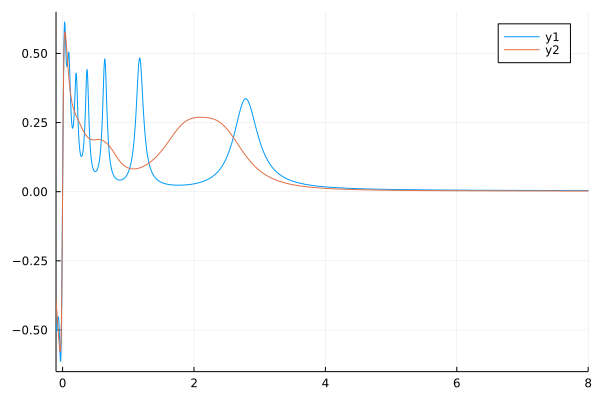

In [31]:
plot(xlim = [-0.1,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(sol.reals.freq), imag.(sol.reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))

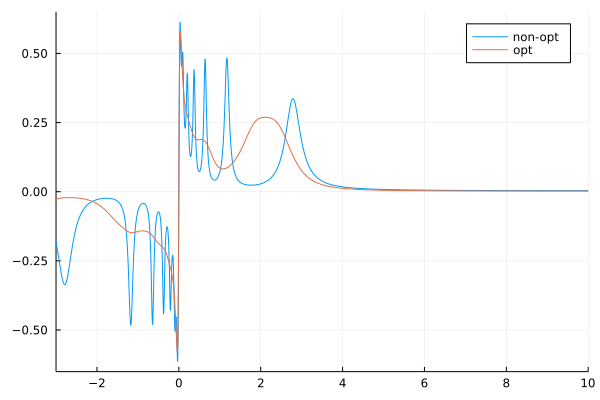

In [32]:
plot(xlim = [-3,10])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")

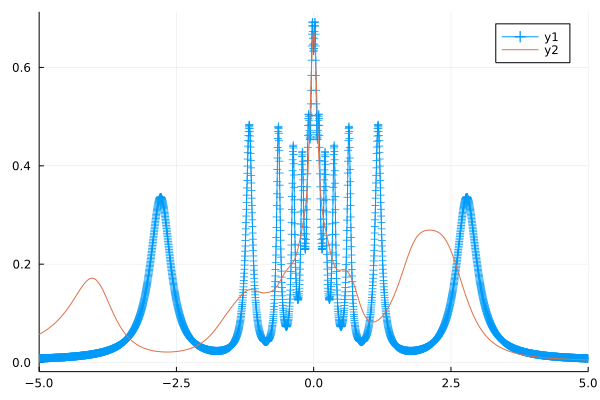

In [33]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [34]:
ComplexF64.(raw_reals.freq[1])

-10.0 + 0.001im